#Active Session II: Regression

#Important Note

Lecture notes and notebooks must not be copied and/or distributed without the express permission of ITS.





#1. Problem Definition: Probe into the Data

In this dataset, we will look into the relationship between airfoil design and its relationship with noise generation. 

This NASA data set was obtained from a series of aerodynamic and acoustic tests of two and three-dimensional airfoil blade sections conducted in an anechoic wind tunnel. It comprises different size NACA 0012 airfoils at various wind tunnel speeds and angles of attack. The span of the airfoil and the observer position were the same in all of the experiments. 

Attribute Information:

This problem has the following inputs:
1. Frequency, in Hertz.
2. Angle of attack, in degrees.
3. Chord length, in meters.
4. Free-stream velocity, in meters per second.
5. Suction side displacement thickness, in meters.

The only output is:
6. Scaled sound pressure level, in decibels. 


# 2. Preparing the enviroment

Import the Python libraries that we will need to (i) load the data, (ii) analyze it, (iii) create our model, (iv) process the results.

In [ ]:
#Importing the necessary libraries
import math
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

In [ ]:
# Data Preparation and Scoring
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LogNorm

In [ ]:
# ML Algorithms to be used
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge



# 3. Pre-processing


## Loading the Data

We need to upload the dataset to Colab enviroment. Pandas library is a practical way to load and read the data from an url. Since the data is only given as tabulated values, we need to add the name of the features as well. 

In [ ]:
# Loading the data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat'
new_names = ['frequency','angle_attack','chord_length','Free-stream_velocity','displacement_thickness','sound_pressure']
data = pd.read_csv(url, names=new_names, delimiter='\t')
data.head()

frequency  angle_attack  ...  displacement_thickness  sound_pressure
0        800           0.0  ...                0.002663         126.201
1       1000           0.0  ...                0.002663         125.201
2       1250           0.0  ...                0.002663         125.951
3       1600           0.0  ...                0.002663         127.591
4       2000           0.0  ...                0.002663         127.461

[5 rows x 6 columns]

## Data Exploration
Here we will look into the statistics of the data, identify any missing values or categorical features that is needed to be further process.

Let’s analyze our dataset first. Use dataset.head(n) to display top n data. You can change dataset.head(n) to dataset.sample(n) to display randomly picked data:

In [ ]:
 data.head(5)

frequency  angle_attack  ...  displacement_thickness  sound_pressure
0        800           0.0  ...                0.002663         126.201
1       1000           0.0  ...                0.002663         125.201
2       1250           0.0  ...                0.002663         125.951
3       1600           0.0  ...                0.002663         127.591
4       2000           0.0  ...                0.002663         127.461

[5 rows x 6 columns]

In [ ]:
data.sample(5)

frequency  angle_attack  ...  displacement_thickness  sound_pressure
1156       1600          17.4  ...                0.016104         126.406
176         400           4.0  ...                0.005796         128.633
1439       5000          12.3  ...                0.036823         112.014
1300       3150           3.3  ...                0.002028         132.114
1106       1600           9.5  ...                0.004614         131.036

[5 rows x 6 columns]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   frequency               1503 non-null   int64  
 1   angle_attack            1503 non-null   float64
 2   chord_length            1503 non-null   float64
 3   Free-stream_velocity    1503 non-null   float64
 4   displacement_thickness  1503 non-null   float64
 5   sound_pressure          1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB


Let's look into the statistics of the data. This is usually a good starting point to have an idea obout the range of the data, its nature, as well as the missing information for different features:

In [ ]:
data.describe()

frequency  angle_attack  ...  displacement_thickness  sound_pressure
count   1503.000000   1503.000000  ...             1503.000000     1503.000000
mean    2886.380572      6.782302  ...                0.011140      124.835943
std     3152.573137      5.918128  ...                0.013150        6.898657
min      200.000000      0.000000  ...                0.000401      103.380000
25%      800.000000      2.000000  ...                0.002535      120.191000
50%     1600.000000      5.400000  ...                0.004957      125.721000
75%     4000.000000      9.900000  ...                0.015576      129.995500
max    20000.000000     22.200000  ...                0.058411      140.987000

[8 rows x 6 columns]

If not defined by the user, you can also explore the features with the following command:

In [ ]:
data.columns


Index(['frequency', 'angle_attack', 'chord_length', 'Free-stream_velocity',
       'displacement_thickness', 'sound_pressure'],
      dtype='object')

It is also possible to explore individual features:

In [ ]:
data['sound_pressure'].median()

125.721

In [ ]:
data['sound_pressure'].mean()

124.83594278110434

### Data Visualization

Another important pre-processing step is the data visualization. Histograms are suitable for a holistic view, where we can probe into the data for each attribute.

We can use hist from matplotlib for that purpose:

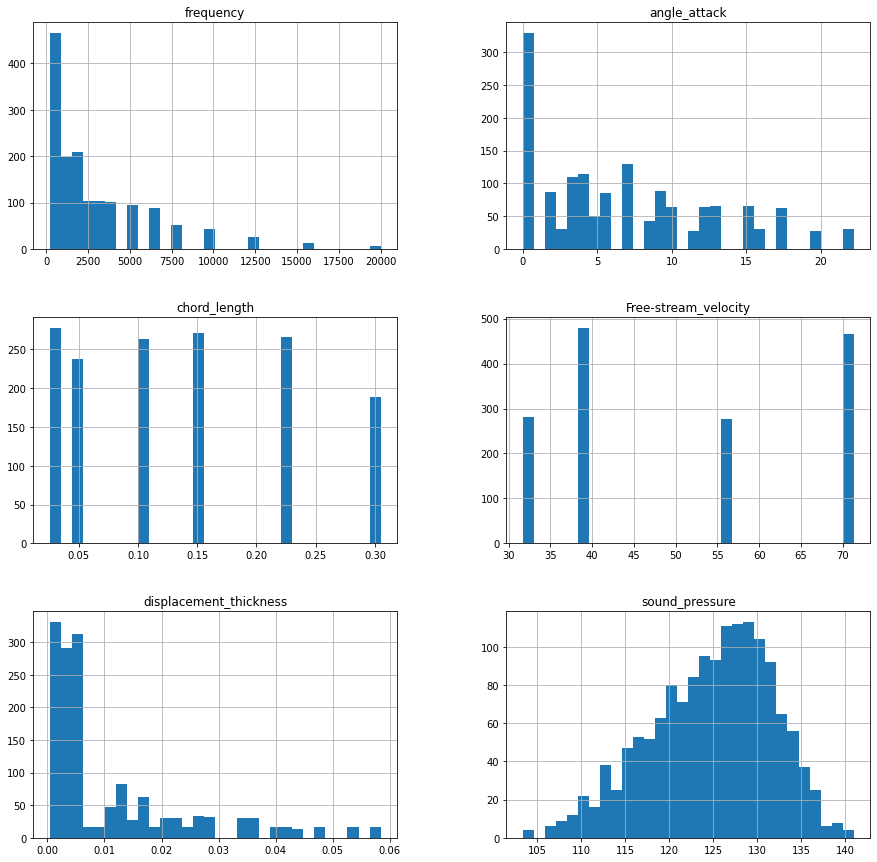

In [ ]:
data.hist(bins=30, figsize=(15,15))
plt.show()

It is always a good exercise to look into the data visually and try to see the distributions of the features. 

### Identify nonnumerical values
Some ML algorithms can not handle non-numerical values (NaN: not a number) so you may need to identify the type of the data for each feature and modify it if necessary. It is also quite common that different feature values are missing for different instances / examples so you may need to decide what to do: (i) omit the instance; (ii) replace them with the mean / median / mode of the feature; (iv) substitute them with a value of your choice.

The following line counts the NaNs for each feature for us: 

In [ ]:
nanCounter = np.isnan(data).sum()
print(nanCounter)

frequency                 0
angle_attack              0
chord_length              0
Free-stream_velocity      0
displacement_thickness    0
sound_pressure            0
dtype: int64


The data was entirely numerical and composed of numbers. We will see in the following sessions how to handle datasets including non-numerical features in a smart way!

It is also a good exercise to check the uniqueness of the dataset, that is, whether there exists values repeating at different instances:

In [ ]:
distinctCounter = data.apply(lambda x: len(x.unique()))
print(distinctCounter)

frequency                   21
angle_attack                27
chord_length                 6
Free-stream_velocity         4
displacement_thickness     105
sound_pressure            1456
dtype: int64


As identified earlier, there are 1503 instances (experimental measurements). Here we realized that these experiments were planned as combinations of 5 input parameters, with unique values of 21x27x6x4x105. 

### Supervised Algorithms: Preparing the Labels

Supervised approach requires labelled data for the training. In this dataset, the objective function is the noise levels (classification) or noise prediction (regression), depending on the question. In both cases, we need to create a feature matrix say X and and label vector Y. We will use Y to train and test our model.

### Creating the Feature Matrix and Labels

In [ ]:
dataX = data.copy().drop(['sound_pressure'],axis=1)
dataY = data['sound_pressure'].copy()

In [ ]:
dataY.sample(5)

1079    128.412
235     128.805
137     118.922
1018    121.474
328     117.154
Name: sound_pressure, dtype: float64

For more pre-processing options; you may check:

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

### Correlation matrix
Now let's try to visualize how correlated the data is by creating a correlation matrix. 

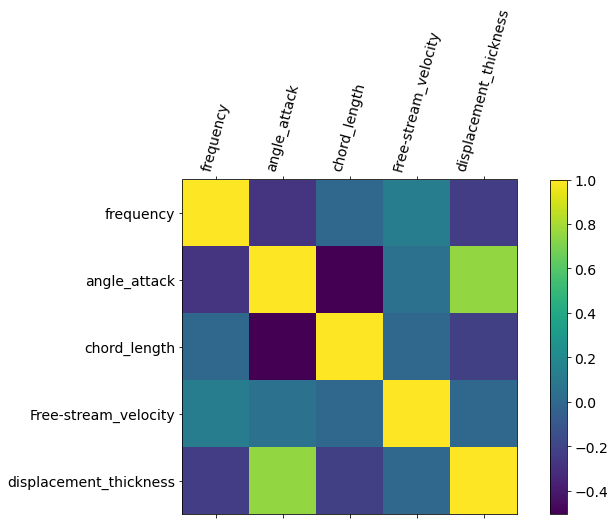

In [ ]:
correlationMatrix = pd.DataFrame(dataX).corr() 

f = plt.figure(figsize=(12, 6))
plt.matshow(correlationMatrix, fignum=f.number)
plt.xticks(range(dataX.shape[1]), dataX.columns, fontsize=14, rotation=75)
plt.yticks(range(dataX.shape[1]), dataX.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

In [ ]:
#we can also simply look at the table via pandas:
correlationMatrix.style.background_gradient(cmap='viridis').set_precision(2)

What do these numbers mean? 

When it is close to 1, it means that there is a strong positive correlation; At the other extreme; –1, it implies that there is a strong negative correlation. For more:

https://en.wikipedia.org/wiki/Correlation_and_dependence

## Preparing the Dataset for Model

We need to divide our entire dataset into fractions so that we have a training set
from which the machine learning algorithm learns. We also need another set to test the predictions of the ML algorithm. There is no golden rule here: you need to consider the size of your entire dataset. Sometimes 5% is more than enough, sometimes we need to divide 1/3 to have enough test samples. 

In our current examples, number of cases is quite low for a ML project. Therefore, lets leave sufficient number of test cases:





In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataX,
dataY, test_size=0.25,
random_state=2020)

Here we have frozen the randomness to make the results reproducible. Otherwise, the results would change at every run. Notice that in classification, we divide the data in a way that labels are distributed in an unbiased way.

## Cross-Validation
Another rule of thumb is to split
the training set into a sub-training sets and a validation set before seeing its true performance on the test set (25% of the dataset reserved above). This policy is called k-fold cross-validation. The training data is divided into k fractions, trained over (k-1) fractions and tested on the k_th. Here the idea is to increase the generalization of the model as much as possible.

https://scikit-learn.org/stable/modules/cross_validation.html

In [ ]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=2020)

## How to calculate the performance?
In any supervised approach, we need to select a cost function to compare ML predictions with the true values (labels). The
ML algorithm will minimize the cost function by changing its fitting parameters. You should spend some time to define what could be the best cost function for my dataset and my objective. 

In our case, we are dealing with regression and we can use it with built-in error functions:

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter



# Regularized Linear Models: Lasso

Overfitting is a common problem in supervised learning. One way to reduce overfitting is to regularize the model by deploying constraints. 

Least Absolute Shrinkage and Selection Operator Regression -- Lasso Regression -- is a regularized version of the Linear Regression approach. In this model, we  add a regularization term (alpha) to the cost function (i.e. mean square error). It is useful in some contexts due to its tendency to prefer solutions with fewer non-zero coefficients, effectively reducing the number of features upon which the given solution is dependent.  

Lets try it on our example!

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso

In [ ]:
# Hyperparameters:
alpha=1.0 #alpha = 0 is equivalent to an ordinary least square but it is not recommended to put zero here!
normalize=False #
max_iter=2000
tol=0.00001
random_state = 2020
selection='cyclic' # (setting to ‘random’) often leads to significantly faster convergence especially when tol is higher than 1e-4.

lasso = Lasso(alpha=alpha, normalize = normalize, max_iter = max_iter, tol = tol, random_state = random_state, selection = selection)

In [ ]:
# Model Training:
#-----------------------------------------------------------------------------
#Lists for storing scores
trainingScores = []
cvScores = []

#DataFrame is a 2-dimensional labeled data structure. You can think of it like a spreadsheet.
#Indexing in pandas means simply selecting particular rows and columns of data from a DataFrame.
#It is  also known as Subset Selection.
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])
model = lasso

#kfold.split will generate indices to split data into training and test set (cv):
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.ravel()):

  #'iloc' can be used when the user doesn’t know the index label:
  #Here we are filtering the data based on indices. Data is divided as 902/225.
  X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

  #Fitting the model according to given data:
  #Note that model refers to Lasso.
  model.fit(X_train_fold, y_train_fold)

  #Lets check how good is the fitting.
  #'score' returns the coefficient of determination R^2 of the prediction. It is defined as (1 - u/v), 
  # where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). 
  #The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
  
  # We will first look in the training dataset:
  scoreTraining = model.score(X_train_fold, y_train_fold)
  #Saving our analysis on the list:
  trainingScores.append(scoreTraining)

  #Lets see how good it is on CV dataset:
  scoreCV = model.score(X_cv_fold, y_cv_fold)
  #Saving our analysis on the list:
  cvScores.append(scoreCV)

  #printing the results:
  print('Training Score: ', scoreTraining)
  print('CV Score: ', scoreCV)

#Lets see the overall score for the entire training set (1127)
scoreLasso = model.score(X_train,y_train)
print('-----------------------------------')
print('Lasso Score: ', scoreLasso)
print('-----------------------------------')


Training Score:  0.27896987073020585
CV Score:  0.2516095744125162
Training Score:  0.2857943519624624
CV Score:  0.22869888607648006
Training Score:  0.26047985457289924
CV Score:  0.3515342167330028
Training Score:  0.26246559047009854
CV Score:  0.3089902492947959
Training Score:  0.29831863391170643
CV Score:  0.186041163494869
-----------------------------------
Lasso Score:  0.27671976494323713
-----------------------------------


In [ ]:
# parameter vector (w in the cost function formula):
print(model.coef_)

[-0.00105991 -0.33121484 -0.          0.10329865 -0.        ]


In [ ]:
# Test Problem:
test_data = data.sample(1,random_state=11).copy()
test_data

frequency  angle_attack  ...  displacement_thickness  sound_pressure
773       6300           0.0  ...                0.000812          130.34

[1 rows x 6 columns]

In [ ]:
# Preparing the input data:
x_testing = test_data.drop(['sound_pressure'],axis=1)

In [ ]:
# Calling model for the prediction:
lasso.predict(x_testing)

array([121.66888533])

## Tuning Hyperparameters

Here you can see that our model fails! So, is it possible to improve the model outcome? We can tune the hyperparameter alpha and use grid search to sweep possible values.

For that purpose, we will use GridSearchCV of scikit learn: we will give the list of hyperparameters and it will use CV to test possible combinations. Here we only have one parameter to play with.

In [ ]:
# Looking for the best alpha value:
alphas = np.logspace(-4, 0, 50)
grid = [{'alpha': alphas}]
#Setting the search:
# For scoring: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
gridSearch = GridSearchCV(lasso, grid, scoring='r2', cv=k_fold, refit=True)
gridSearch.fit(X_train, y_train)
results = gridSearch.cv_results_
print('Best R^2 obtained:', gridSearch.best_score_)
print('alpha value for the best case:', gridSearch.best_estimator_.alpha)

Best R^2 obtained: 0.5010820279002012
alpha value for the best case: 0.0001


In [ ]:
#Saving the best parameters back to model:
lasso = gridSearch.best_estimator_
#Alpha value of the model:
lasso.alpha

0.0001

In [ ]:
#Lets check the keys to plot them:
results.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_alpha', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

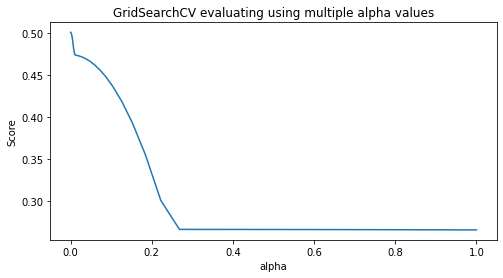

In [ ]:
# Plotting the results
plt.figure(figsize=(8, 4))
plt.title("GridSearchCV evaluating using multiple alpha values",
          fontsize=12)
plt.xlabel("alpha")
plt.ylabel("Score")
# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_alpha'].data, dtype=float)
Y_axis = np.array(results['mean_test_score'].data, dtype=float)
plt.plot(X_axis,Y_axis)
plt.show()

It looks like the smallest regularization is better. This is not the usual case though!

In [ ]:
# Test Problem:
test_data

frequency  angle_attack  ...  displacement_thickness  sound_pressure
773       6300           0.0  ...                0.000812          130.34

[1 rows x 6 columns]

In [ ]:
lasso.predict(x_testing)

array([125.97272689])

# Elastic Net

Elastic Net is another linear regression model that can be used with regularization. In this case, we have two terms for the job: the model is trained with both
l1 and l2-norm regularization of the coefficients. It allows to train a sparse model similar to Lasso, while still maintaining the properties of an older approach called Ridge (see lecture notes). The hyperparameters of the model are the 'alpha' and 'l1_ratio'. 

In [ ]:
# Hyperparameters:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html
alpha=1.0 #alpha = 0 is equivalent to an ordinary least square but it is not recommended to put zero here!
l1_ratio=0.5 # This is new!!
normalize=False #
max_iter=2000
tol=0.00001
random_state = 2020
selection='cyclic' # (setting to ‘random’) often leads to significantly faster convergence especially when tol is higher than 1e-4.

elastic_net = ElasticNet(alpha=alpha, l1_ratio = l1_ratio, normalize = normalize, max_iter = max_iter, tol = tol, random_state = random_state, selection = selection)

In [ ]:
# Model Training:
#-----------------------------------------------------------------------------
#Lists for storing scores
trainingScores = []
cvScores = []

#DataFrame is a 2-dimensional labeled data structure. You can think of it like a spreadsheet.
#Indexing in pandas means simply selecting particular rows and columns of data from a DataFrame.
#It is  also known as Subset Selection.
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])

####Modified###
model = elastic_net

#kfold.split will generate indices to split data into training and test set (cv):
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.ravel()):

  #'iloc' can be used when the user doesn’t know the index label:
  #Here we are filtering the data based on indices. Data is divided as 902/225.
  X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

  #Fitting the model according to given data:
  #Note that model refers to Lasso.
  model.fit(X_train_fold, y_train_fold)

  #Lets check how good is the fitting.
  #'score' returns the coefficient of determination R^2 of the prediction. It is defined as (1 - u/v), 
  # where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). 
  #The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
  
  # We will first look in the training dataset:
  scoreTraining = model.score(X_train_fold, y_train_fold)
  #Saving our analysis on the list:
  trainingScores.append(scoreTraining)

  #Lets see how good it is on CV dataset:
  scoreCV = model.score(X_cv_fold, y_cv_fold)
  #Saving our analysis on the list:
  cvScores.append(scoreCV)

  #printing the results:
  print('Training Score: ', scoreTraining)
  print('CV Score: ', scoreCV)

#Lets see the overall score for the entire training set (1127)

####Modified###
scoreElasticNet = model.score(X_train,y_train)
print('-----------------------------------')
print('Elastic Net Score: ', scoreElasticNet)
print('-----------------------------------')


Training Score:  0.2794398699828424
CV Score:  0.25357889269695333
Training Score:  0.28622123379488085
CV Score:  0.22900533751460972
Training Score:  0.26090804762340025
CV Score:  0.35117085887540533
Training Score:  0.26292888317361696
CV Score:  0.31049180155051226
Training Score:  0.2987457563346132
CV Score:  0.1847427649804091
-----------------------------------
Elastic Net Score:  0.2768008416380012
-----------------------------------


## Tuning ElasticNet via Grid Search

Above you can see that our model is not really good! Is it possible to improve the model outcome? 

We can tune the hyperparameters by using the use grid search to sweep possible values.

For that purpose, we will use `GridSearchCV` of scikit learn: we will give the list of hyperparameters and it will use CV to test possible combinations. Here we have two parameters to play with: $\alpha$ and its ratio.

In [ ]:
# Looking for the best alpha and ratio value:
alphas = np.logspace(-4, 0, 10)
l1_ratios = np.logspace(-3,0,10)
grid = {'alpha': alphas,'l1_ratio':l1_ratios}

#Setting the search:
# For scoring: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
gridSearch = GridSearchCV(elastic_net, grid, scoring='r2', cv=k_fold, refit=True)
gridSearch.fit(X_train, y_train)

#Saving results:
results = gridSearch.cv_results_

print('Best R^2 obtained:', gridSearch.best_score_)
print('alpha value for the best case:', gridSearch.best_estimator_.alpha)
print('l1_ratio value for the best case:', gridSearch.best_estimator_.l1_ratio)

Best R^2 obtained: 0.5010820279002012
alpha value for the best case: 0.0001
l1_ratio value for the best case: 1.0


In [ ]:
#Saving the best parameters back to model:
elastic_net = gridSearch.best_estimator_

#Alpha and l1 values of the model:
elastic_net.alpha, elastic_net.l1_ratio

(0.0001, 1.0)

In [ ]:
# Test Problem:
test_data

frequency  angle_attack  ...  displacement_thickness  sound_pressure
773       6300           0.0  ...                0.000812          130.34

[1 rows x 6 columns]

In [ ]:
elastic_net.predict(x_testing)

array([125.97272689])

## Heat map as a visualisation tool for grid search

Now lets look closer to the grid search results and analyze the landscape via a heat map, as now we have 2 hyperparameters to play with.

In [ ]:
# It is good practice to check how data is organized.
# Lets convert the results into a dataframe first:
results_overview = pd.DataFrame(results)
# Now we can visualize the data to learn about column names and indices:
display(results_overview.head())

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0       0.003707      0.000705  ...        0.023079               13
1       0.002411      0.000105  ...        0.023082               12
2       0.002647      0.000329  ...        0.023087               11
3       0.002526      0.000220  ...        0.023099               10
4       0.002434      0.000043  ...        0.023125                9

[5 rows x 15 columns]

Text(0.5, 1.0, 'Heat Map of R2 scores as a fucntion of l1_ratio and alpha')

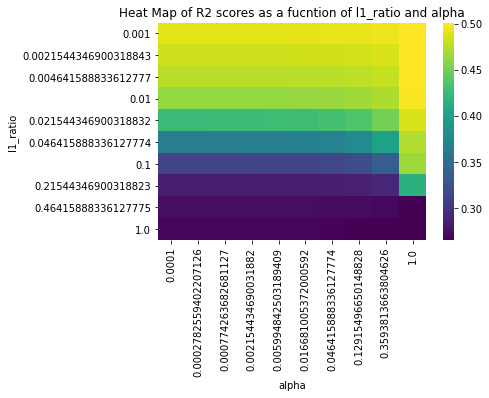

In [ ]:
# plot the mean cross-validation scores:
# Since we know the column names, it is easier to read and further manuplate the data.
# Lets create an array 10 x 10, which is the # combinations we tested with hyperparameters.
scores = np.array(results_overview.mean_test_score).reshape(10, 10)

#Simple Drawing
sns.heatmap(scores,cmap='viridis',xticklabels=grid['alpha'],yticklabels=grid['l1_ratio'])

#A bit makeup:
plt.xlabel("alpha"), plt.ylabel("l1_ratio")
plt.title("Heat Map of R2 scores as a fucntion of l1_ratio and alpha")

Heat maps are good to see the influence of hyperparameters on the error space. In our case, it is good to focus on top right corner. 

Note that our problem is nonlinear so these linear models can not describe its behaviour. That is, even if you optimize the hyperparameters, the model seems to underfit the data. 

Lets check that idea with **learning curves.**

## Learning Curve

In previous exercises, we have used cross-validation to get an idea about the generalization performance of the model. If the performance is much worse for CV, then it is overfitting. If they are both bad, then it is probably underfitting the data and we need more complex models.

We can also visualize how the model is learning via 'Learning Plots'. The idea is simple: you need to train the model with growing size of training data and see its performance. Let's do that by defining a function for us:

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01210177555345966, tolerance: 0.0013691586475
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4383943526582352, tolerance: 0.0021703116933333337
  positive)


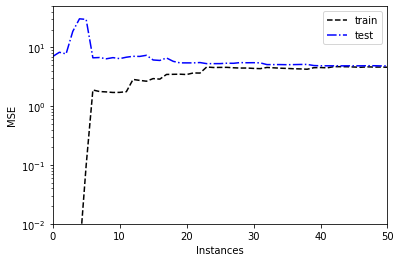

In [ ]:
# Defining our function to run the model and see the evolution of error>
def plot_learning_curves(model, X_train, X_test, y_train, y_test):
  #Empty lists for data storage:
  train_errors, val_errors = [], []
  # Remember, we will look at the error as model is trained with more data.
  # So we will make predictions with increasing instance sizes for both the training set and test set.
  for m in range(1, len(X_train)):
    #Model fitting:
    model.fit(X_train[:m], y_train[:m])
    #Predicting for the training data:
    y_train_predict = model.predict(X_train[:m])
    #Predicting for the test data:
    y_test_predict = model.predict(X_test)
    #Saving the errors for the plot for a given data size:
    train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
    val_errors.append(mean_squared_error(y_test, y_test_predict))
  
  # Plotting the results:
  plt.plot(np.sqrt(train_errors), "k--", linewidth=1.5, label="train")
  plt.plot(np.sqrt(val_errors), "b-.", linewidth=1.5, label="test")
  plt.legend()
  plt.xlim(0, 50),  plt.ylim(0.01,50)
  plt.yscale("log")
  plt.xlabel("Instances"),  plt.ylabel("MSE")
  
# Calling our function to draw the learning curve for elastic net:
plot_learning_curves(elastic_net,X_train, X_test, y_train, y_test)

What does this plot tell us? As the # instances increases, the error in the training set increases as the model cannot fit very well to the increasing volume of data. After around 30 instances, we reach a plateau, after which the mean error does not change much. If we look at the blueline, at few examples, model fails to predict the test data as it has little experience to generalize. **As model learns**, the error goes down and eventually reaches the same plateau. Yet the **error** is too **high** and the **model is too simple** to capture the nonlinearity. 

# Support Vector Machines

Lets try a better approach: SVM. It is a popular method and can be used for classification, regression and even outliers detection. Model is versitile: different Kernel functions can be implemented for the decision function. In SVM, we construct a hyperplane via these Kernel functions in a higher dimensional space and we look for the optimal hyperplane that best separates the data with the highest margin. Linear approach is the fastest but performs poorer for nonlinear datasets. 

In sci-kit learn, we have three options to implement and you can check the details from here:
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#


Lets try SVM for our dataset!

## Normalizing the data
We will normalize the data before feeding it into SVM as it is very critical for this model (see Lecture notes).

In [ ]:
#Rescaling the data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
#Looking into the statistics again:
dataX.describe()

frequency  angle_attack  ...  Free-stream_velocity  displacement_thickness
count  1.503000e+03  1.503000e+03  ...          1.503000e+03            1.503000e+03
mean   2.837975e-16 -3.495393e-16  ...         -8.558246e-16            2.866045e-16
std    1.000333e+00  1.000333e+00  ...          1.000333e+00            1.000333e+00
min   -8.524068e-01 -1.146403e+00  ...         -1.230809e+00           -8.169263e-01
25%   -6.620227e-01 -8.083458e-01  ...         -7.233448e-01           -6.545613e-01
50%   -4.081773e-01 -2.336486e-01  ...         -7.233448e-01           -4.702979e-01
75%    3.533590e-01  5.269801e-01  ...          1.312935e+00            3.374462e-01
max    5.430267e+00  2.606032e+00  ...          1.312935e+00            3.595917e+00

[8 rows x 5 columns]

The next step is to divide the data as the training set and the test set. We will use the same ratio of 3 to 1: 

In [ ]:
#After the normalization, we need to update the splitted arrays again:
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.25, random_state=2020)

## Model Training and Predictions

As we have seen in the lecture, there are 3 important hyperparameters to decide: C, epsilon and kernel. We also need to feed the tol value as we are solving a convex optimization problem.

In [ ]:
# Hyperparameters:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#

#__________________________________________________________________________________________
#___Notes__________________________________________________________________________________
#Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. 

#The parameter C, common to all SVM kernels, trades off misclassification of training examples 
#against simplicity of the decision surface. 
#A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. 
#The strength of the regularization is inversely proportional to C. Large C => little regularization; Low C => higher regularization

#gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.
#__________________________________________________________________________________________

kernel='linear' 
gamma='scale' #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. When scaled, uses 1 / (n_features * X.var()) as value of gamma.
C=1.0
epsilon=0.1    # Default
shrinking=True # Whether to use the shrinking heuristic. 
tol=0.00001

#Setting the model:
svr = SVR(kernel= kernel, gamma=gamma, tol=tol, C=C, epsilon=epsilon, shrinking=shrinking)

 

In [ ]:
# Model Training:
#-----------------------------------------------------------------------------
#Lists for storing scores
trainingScores = []
cvScores = []

#DataFrame is a 2-dimensional labeled data structure. You can think of it like a spreadsheet.
#Indexing in pandas means simply selecting particular rows and columns of data from a DataFrame.
#It is  also known as Subset Selection.
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])

####Modified###
model = svr

#kfold.split will generate indices to split data into training and test set (cv):
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.ravel()):

  #'iloc' can be used when the user doesn’t know the index label:
  #Here we are filtering the data based on indices. Data is divided as 902/225.
  X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

  #Fitting the model according to given data:
  #Note that model refers to Lasso.
  model.fit(X_train_fold, y_train_fold)

  #Lets check how good is the fitting.
  #'score' returns the coefficient of determination R^2 of the prediction. It is defined as (1 - u/v), 
  # where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). 
  #The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
  
  # We will first look in the training dataset:
  scoreTraining = model.score(X_train_fold, y_train_fold)
  #Saving our analysis on the list:
  trainingScores.append(scoreTraining)

  #Lets see how good it is on CV dataset:
  scoreCV = model.score(X_cv_fold, y_cv_fold)
  #Saving our analysis on the list:
  cvScores.append(scoreCV)

  #printing the results:
  print('Training Score: ', scoreTraining)
  print('CV Score: ', scoreCV)

#Lets see the overall score for the entire training set (1127)

####Modified###
scoreSVM = model.score(X_train,y_train)
print('-----------------------------------')
print('SVM Regression Score: ', scoreSVM)
print('-----------------------------------')

Training Score:  0.5070411564922929
CV Score:  0.44091910713675814
Training Score:  0.5014721569064833
CV Score:  0.4724269018135753
Training Score:  0.49612539211954243
CV Score:  0.5155483107356797
Training Score:  0.4821381566710744
CV Score:  0.5371685456955024
Training Score:  0.5007995135448318
CV Score:  0.47452472828747555
-----------------------------------
SVM Regression Score:  0.49616654259904086
-----------------------------------


## Tuning SVM Hyperparameters with Grid Search



The model prediction is not good. So we need to play with the hyper parameters! As an example, here we can play with the kernel and C values. 

Try yourselves with the epsilon and gamma as well.

In [ ]:
kernels = ['poly','rbf','sigmoid']
Cs = np.logspace(0, 3, 25)
#Setting up the grid:
grid = {'kernel': kernels,'C':Cs}

#Setting the search:
# For scoring: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

gridSearch = GridSearchCV(svr, grid, scoring='r2', cv=k_fold, refit=True)
gridSearch.fit(X_train, y_train)
results = gridSearch.cv_results_

print('Best R^2 obtained:', gridSearch.best_score_)
print('gamma value for the best case:', gridSearch.best_estimator_.gamma)
print('kernel value for the best case:', gridSearch.best_estimator_.kernel)
print('C value for the best case:', gridSearch.best_estimator_.C)

Best R^2 obtained: 0.8290567419308177
gamma value for the best case: scale
kernel value for the best case: rbf
C value for the best case: 1000.0


In [ ]:
#Saving the best parameters back to model:
svr = gridSearch.best_estimator_
#Alpha and l1 values of the model:
svr.kernel, svr.C, svr.gamma

('rbf', 1000.0, 'scale')

In [ ]:
# Test Problem:
test_data = X_test.sample(1,random_state=11).copy()
test_data

frequency  angle_attack  ...  Free-stream_velocity  displacement_thickness
317  -0.757215     -0.470289  ...              0.298007               -0.521357

[1 rows x 5 columns]

In [ ]:
#Making a prediction with the model:
svr.predict(test_data)

array([129.34503709])

In [ ]:
#Checking for the true value:
y_test[test_data.index]

317    127.314
Name: sound_pressure, dtype: float64

In [ ]:
#Lets try a self-defined error for this instance:
relative_error = abs(model.predict(test_data)-y_test[test_data.index])/y_test[test_data.index]*100
print('Relative percentage error is:',round(relative_error.values[0],2),'%')

Relative percentage error is: 0.21 %


## Visualizing the learning curve for SVM

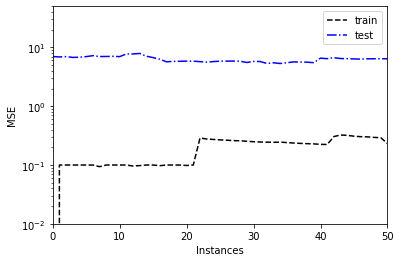

In [ ]:
#Note:
# The function is already defined in ElasticNet.
#  
# Calling our function to draw the learning curve for SVM:
plot_learning_curves(svr,X_train, X_test, y_train, y_test)

# An Alternative Linear Approach: Bayesian Regression

This is a self-study exercise for you! Look into the explainations in the scikit learn user guides if needed.

https://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html


A good exercise would be the implementation of the grid search for this method as well. Follow the above examples and repeat the procedure here!

Check also:

https://scikit-learn.org/stable/auto_examples/linear_model/plot_bayesian_ridge.html

https://scikit-learn.org/stable/auto_examples/linear_model/plot_bayesian_ridge_curvefit.html





In [ ]:
# Hyperparameters:

alpha_1 = 1e-06
alpha_2 = 1e-06 
lambda_1 = 1e-06
lambda_2 = 1e-06
normalize = False

brr = BayesianRidge(alpha_1=alpha_1,alpha_2=alpha_2, lambda_1=lambda_1, lambda_2=lambda_2)

In [ ]:
# Model Training:
#-----------------------------------------------------------------------------
#Lists for storing scores
trainingScores = []
cvScores = []

#DataFrame is a 2-dimensional labeled data structure. You can think of it like a spreadsheet.
#Indexing in pandas means simply selecting particular rows and columns of data from a DataFrame.
#It is  also known as Subset Selection.
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])

####Modified###
model = brr

#kfold.split will generate indices to split data into training and test set (cv):
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.ravel()):

  #'iloc' can be used when the user doesn’t know the index label:
  #Here we are filtering the data based on indices. Data is divided as 902/225.
  X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

  #Fitting the model according to given data:
  #Note that model refers to Lasso.
  model.fit(X_train_fold, y_train_fold)

  #Lets check how good is the fitting.
  #'score' returns the coefficient of determination R^2 of the prediction. It is defined as (1 - u/v), 
  # where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). 
  #The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
  
  # We will first look in the training dataset:
  scoreTraining = model.score(X_train_fold, y_train_fold)
  #Saving our analysis on the list:
  trainingScores.append(scoreTraining)

  #Lets see how good it is on CV dataset:
  scoreCV = model.score(X_cv_fold, y_cv_fold)
  #Saving our analysis on the list:
  cvScores.append(scoreCV)

  #printing the results:
  print('Training Score: ', scoreTraining)
  print('CV Score: ', scoreCV)

#Lets see the overall score for the entire training set (1127)

####Modified###
scoreBRR = model.score(X_train,y_train)
print('-----------------------------------')
print('BR Regression Score: ', scoreBRR)
print('-----------------------------------')

Training Score:  0.5225467304029023
CV Score:  0.4594941689836572
Training Score:  0.5138005114174333
CV Score:  0.4944081366287578
Training Score:  0.506928624890352
CV Score:  0.5277908126767137
Training Score:  0.4971709795254716
CV Score:  0.5481390789891198
Training Score:  0.5183418178830451
CV Score:  0.47597628705725725
-----------------------------------
BR Regression Score:  0.5104648562432805
-----------------------------------


In [ ]:
# Test Problem:
test_data = X_test.sample(1,random_state=121).copy()
test_data

frequency  angle_attack  ...  Free-stream_velocity  displacement_thickness
722   0.353359      0.983357  ...             -0.723345                3.595917

[1 rows x 5 columns]

In [ ]:
y_mean, y_std = brr.predict(test_data, return_std=True)
print ('Predicted value is  %5.2f' %y_mean[0], ' with a SD of  %5.2f' %y_std)

Predicted value is  112.52  with a SD of   4.91


In [ ]:
print ('Test value is  %5.2f' %y_test._get_value(test_data.index.ravel()[0]))

Test value is  104.50


In [ ]:
relative_error = abs(model.predict(test_data)-y_test[test_data.index])/y_test[test_data.index]*100
print('Relative percentage error is:',round(relative_error.values[0],2),'%')

Relative percentage error is: 7.88 %


The prediction is within 2 $\sigma$ interval!

## Learning Curve

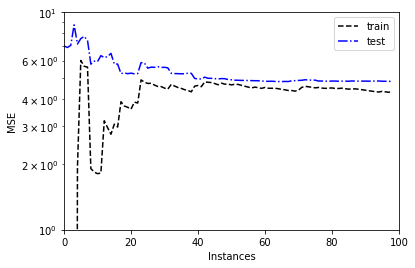

In [ ]:
def plot_learning_curves(model, X_train, X_test, y_train, y_test):
  train_errors, val_errors = [], []
  for m in range(1, 100):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_test_predict = model.predict(X_test)
    train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
    val_errors.append(mean_squared_error(y_test, y_test_predict))
  plt.plot(np.sqrt(train_errors), "k--", linewidth=1.5, label="train")
  plt.plot(np.sqrt(val_errors), "b-.", linewidth=1.5, label="test")
  plt.legend()
  plt.xlim(0, 100),  plt.ylim(1,10)
  plt.yscale("log")
  plt.xlabel("Instances"),  plt.ylabel("MSE")
  

plot_learning_curves(brr,X_train, X_test, y_train, y_test)

# Reading Material

Christopher M. Bishop: Pattern Recognition and Machine Learning, Chapter 3, 7

Mehryar Mohri, Foundations of Machine Learning, second edition, Chapter 5, 11

https://www.jmlr.org/papers/volume1/tipping01a/tipping01a.pdf